# HA 3 - GPs and TS

In this HA, you can get 40points in total
* reproducing the plots gives you full grade
* if example is not reproduced we evaluate "how many changes are required to get to the full grade"
* each change couns for 2 points

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [2]:
passengers = pd.read_csv("AirPassengers.csv", parse_dates=["Month"])
passengers['n_month'] = passengers.index.to_numpy() - passengers.shape[0] // 2

marginal_std = passengers["#Passengers"][passengers["#Passengers"] > 0].std()
marginal_mean = passengers["#Passengers"][passengers["#Passengers"] > 0].mean()

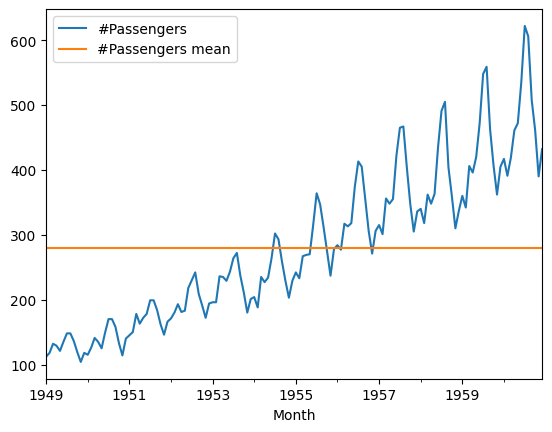

In [3]:
passengers['#Passengers mean'] = marginal_mean

passengers.set_index('Month').drop(columns='n_month').plot()

del passengers['#Passengers mean']

## Part 1. Trend Model (10pt)

In this part of the home assignment, you'll need to create Marginal gaussian Process to model number of passengers.

1. You should notice, that there is decent amount of seasonality in data
2. There is also Trend in data
3. Not as useless, number of passengers is a positve number

### Practical advices

It is a common practice in applied stats to replace **a part of** prior predictive study
```python
# for data in R^n
time_series: pd.Series
marginal_std = time_series.std()
marginal_mean = time_series.mean()
# for data in R_+^n (Positive data)
marginal_log_std = np.log(time_series[time_series>0]).std()
marginal_log_mean = np.log(time_series[time_series>0]).mean()
```
This does not nessesarily replace all the investigations into "how does the model look like", but significantly improves "ease of use" of Bayesian models.

In [4]:
marginal_log_std = np.log(passengers["#Passengers"][passengers["#Passengers"] > 0]).std()
marginal_log_mean = np.log(passengers["#Passengers"][passengers["#Passengers"] > 0]).mean()

Fixed numbers are too concrete, so some of the uncertainty to help the model find optimal marginals is needed.

> for our log scale data, std is on the log scale for both mean and std

In [5]:
log_empirical_uncertainty = 0.15

Now, implement the model

$$
\begin{align}
\text{mlogmean} &\sim \operatorname{Normal}(\text{marginal-log-mean}, \text{log-empirical-uncertainty}) \\
\text{trend} &\sim \operatorname{Normal}(0,?) \\
\text{eps} &\sim \operatorname{LogNormal}(?,?) \\
\text{obs} &\sim \operatorname{LogNormal}(f(\text{mlogmean},\text{trend}),\text{eps})\\
\end{align}
$$

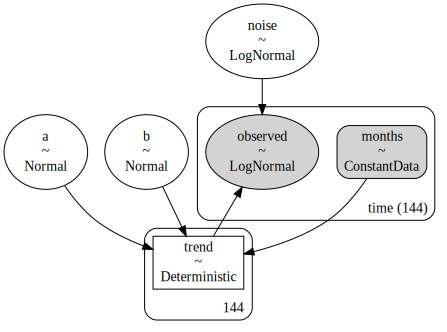

In [6]:
with pm.Model(coords={'time': passengers['Month']}) as model1:
    # make months data: n x n
    months = pm.ConstantData(name='months', value=passengers.n_month, dims='time')

    # constructing general trend: a + b * x
    # a: in terms of log, %
    a = pm.Normal(name='a', mu=marginal_log_mean, sigma=log_empirical_uncertainty)

    # b: in terms of absolute values
    b = pm.Normal(name='b', mu=0, sigma=log_empirical_uncertainty)

    # trend: in terms of log, %
    trend = pm.Deterministic(name='trend', var=a + b * months)

    # constructing noise
    noise = pm.LogNormal(name='noise', mu=log_empirical_uncertainty, sigma=marginal_log_std)

    # passengers likelihood
    observed = pm.LogNormal(name='observed', mu=trend, sigma=noise, dims='time', observed=passengers['#Passengers'])

    # fit model
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    trace.extend(pm.sample_posterior_predictive(trace))
    trace.to_netcdf('trace1.nc')

pm.model_to_graphviz(model1)

Make sure number od passengers does not explode dramatically.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


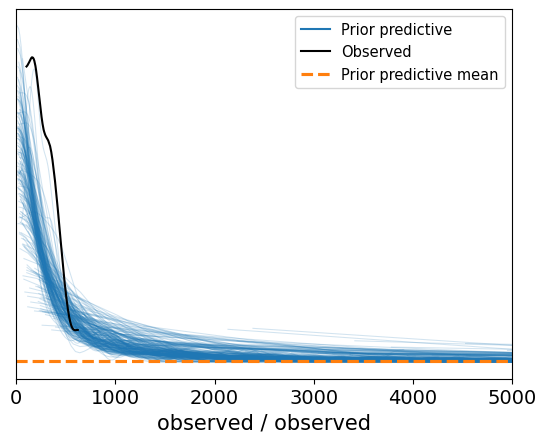

In [7]:
az.plot_ppc(prior, group='prior').set(xlim=[0, 5000]);

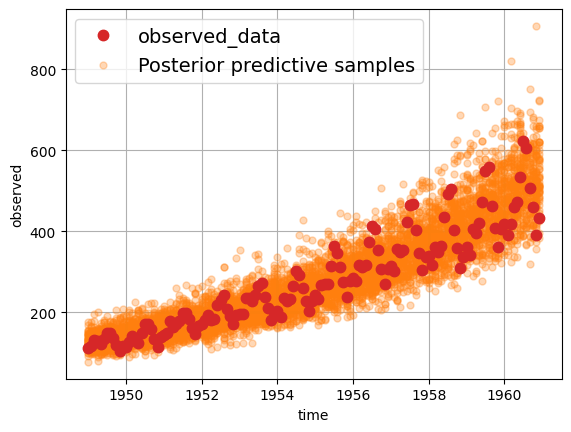

In [8]:
az.plot_lm('observed', trace);

## Part 2. Simple GP (10pt)

Copy paste your model to the nest cell, name it model2, we are going to replace the model with Gaussian Process Model

$$
\begin{align}
\text{mlogmean} &\sim \operatorname{Normal}(?,?) \\
\text{trend} &\sim \operatorname{Normal}(0,?) \\
\text{eps} &\sim \operatorname{LogNormal}(?,?) \\
\alpha_s &\sim \operatorname{LogNormal}(?, ?)\\
l_s &\sim \operatorname{Gamma}(?, ?)\\
K &= \alpha_s\operatorname{Periodic}(\text{period}=12, l_s)\\
\text{seasonal} &\sim \mathcal{GP}(\text{time}, 0, K)\\
\text{obs} &\sim \operatorname{LogNormal}(f(\text{mlogmean},\text{trend}, \text{seasonal}),\text{eps})\\
\end{align}
$$
where for $\operatorname{Periodic}(\text{period}=12, \dots)$ you should initialize **lengthscale** and **magnitude**

read
* https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html
* https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html

sample: 100%|██████████| 2000/2000 [17:00<00:00,  1.96it/s]


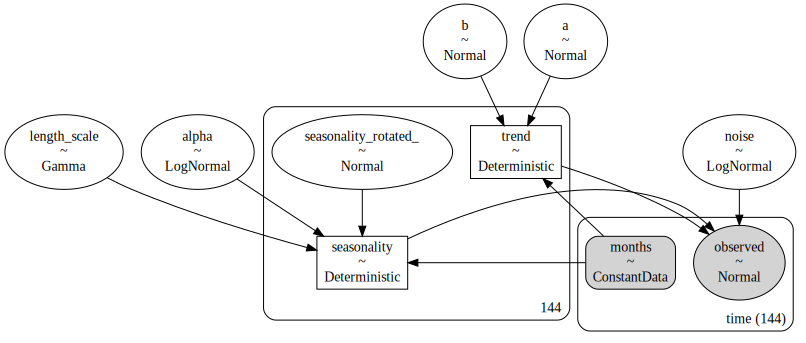

In [9]:
import pymc.sampling.jax

with pm.Model(coords=dict(time=passengers['Month'])) as model2:
    # make months data: n x n
    months = pm.ConstantData(name='months', value=passengers.n_month, dims='time')

    # constructing general trend: a + b * x
    # a: in terms of log, %
    a = pm.Normal(name='a', mu=marginal_log_mean, sigma=log_empirical_uncertainty)

    # b: in terms of absolute values
    b = pm.Normal(name='b', mu=0, sigma=log_empirical_uncertainty)

    # trend: in terms of log, %
    trend = pm.Deterministic(name='trend', var=a + b * months)

    # constructing noise
    noise = pm.LogNormal(name='noise', mu=log_empirical_uncertainty, sigma=marginal_log_std)

    # Gaussian Processes components
    length_scale = pm.Gamma(name='length_scale', mu=3, sigma=1)
    periodic = pm.gp.cov.Periodic(input_dim=1, period=12, ls=length_scale)
    alpha = pm.LogNormal(name='alpha', mu=0, sigma=1)

    assert isinstance(periodic, pm.gp.cov.Periodic)

    gaussian_processes = pm.gp.Latent(cov_func=periodic * alpha)
    seasonality = gaussian_processes.prior('seasonality', months[:, None])

    # passengers likelihood
    observed = pm.Normal(name='observed', mu=trend + seasonality, sigma=noise,
                         observed=passengers['#Passengers'].apply(np.log), dims='time')

    # fit model
    trace = pymc.sampling.jax.sample_numpyro_nuts(chains=2, chain_method='vectorized')
    trace.extend(pm.sample_posterior_predictive(trace))
    trace.to_netcdf('trace2.nc')

pm.model_to_graphviz(model2)

We are going to use fins MAP to quickly esimate the GP

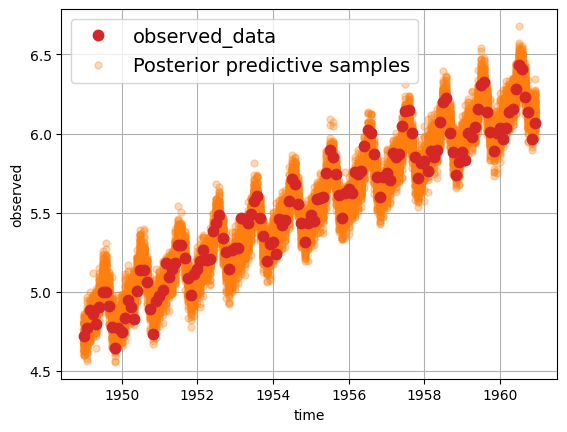

In [11]:
az.plot_lm('observed', trace, num_samples=100);

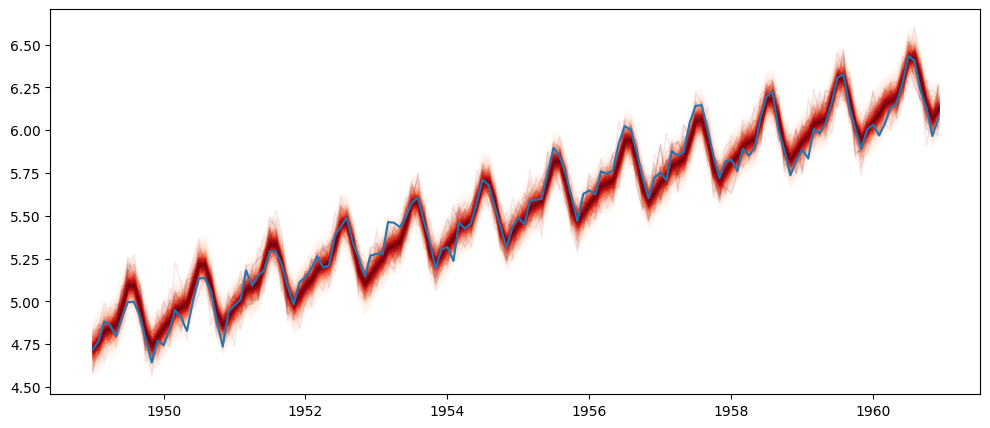

In [12]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12, 5)); ax = fig.gca()

plot_gp_dist(
    ax=ax,
    samples=az.extract(trace.posterior_predictive)['observed'].T,
    x=trace.posterior_predictive.time.values,
)
ax.plot(trace.posterior_predictive.time.values, passengers['#Passengers'].apply(np.log))

plt.show()

You can try running simple sampling, but it will be not as fast and there will be diverging samples.

> This is optional, you can do it out of your curiosity

## Part 3. Fourier features (10pt)

The gaussian process we created is slow in sampling. Practitioners rarely use GPs like above because of that.

There are practical approaches to deal with seasonal time series models. One of the most favorite one is fourier features.

* https://arxiv.org/abs/2006.10739
* Prophet uses Fourier features https://github.com/facebook/prophet/blob/c00f6a2d72229faa6acee8292bc01e14f16f599c/python/prophet/forecaster.py#L455
* These should not be underestimated

To make practical use of them, here is the snippet to create these features given required periodicity.

In [13]:
from collections import namedtuple
from enum import Enum

Season = namedtuple(typename='Season', field_names=["period", "order"])

class Daily(Season, Enum):
    Week = 7.0, 3
    Year = 365.25, 5
    Month = 365.25 / 12, 10

class Monthly(Season, Enum):
    Year = 12, 5
    Month = 1, 10

In [14]:
Daily.Year

<Daily.Year: Season(period=365.25, order=5)>

In [15]:
def fourier_series(
    time: pt.TensorLike,
    *,
    season: Season,
) -> pt.TensorVariable:
    """Generate Fourier Series.

    Parameters
    ----------
    time : pt.TensorLike
        Time Dimension
    season: Season
        Contains period and order of approximation

    Returns
    -------
    pt.TensorVariable
        Fourier basis functions scaled to have unit variance across time dimension
    """
    if (season.order * 2) > season.period:
        raise ValueError("(season.order * 2) > season.period length causes correlated feature")
    time = pt.as_tensor(time)
    orders = pt.arange(1, season.order + 1)
    return 2**0.5 * pt.stack(
        [
            pt.sin(2 * pt.pi * time[:, None] * orders / season.period),
            pt.cos(2 * pt.pi * time[:, None] * orders / season.period),
        ],
        axis=-1,
    ).reshape((-1, season.order * 2))

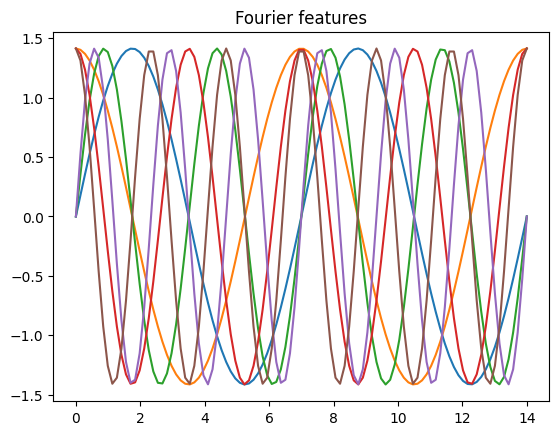

In [16]:
x = np.linspace(0, 14, 100)
plt.plot(x, fourier_series(x, season=Daily.Week).eval())
plt.title("Fourier features");

Now replace the seasonal latent GP with Yearly seasonality as a regression.

```python
alpha = pm.Normal("alpha", 0, sigma, shape=season.order * 2)
features = fourier_series(months, season=season)
seasonality = features @ alpha
```

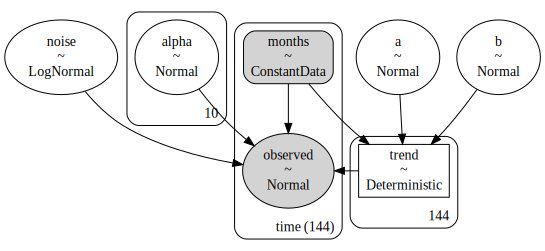

In [35]:
with pm.Model(coords=dict(time=passengers['Month'])) as model3:
    # make months data: n x n
    months = pm.ConstantData(name='months', value=passengers.n_month, dims='time')

    # constructing general trend: a + b * x
    # a: in terms of log, %
    a = pm.Normal(name='a', mu=marginal_log_mean, sigma=log_empirical_uncertainty)

    # b: in terms of absolute values
    b = pm.Normal(name='b', mu=0, sigma=log_empirical_uncertainty)

    # trend: in terms of log, %
    trend = pm.Deterministic(name='trend', var=a + b * months)

    # constructing noise
    noise = pm.LogNormal(name='noise', mu=log_empirical_uncertainty, sigma=marginal_log_std)

    # Fourier Features components
    alpha = pm.Normal(name='alpha', mu=0, sigma=1, shape=Monthly.Year.order * 2)
    seasonality = fourier_series(time=months, season=Monthly.Year) @ alpha

    # passengers likelihood
    observed = pm.Normal(name='observed', mu=trend + seasonality, sigma=noise, observed=passengers['#Passengers'].apply(np.log), dims='time')

    # fit model
    trace = pm.sample()
    trace.extend(pm.sample_posterior_predictive(trace))
    trace.to_netcdf('trace3.nc')

pm.model_to_graphviz(model3)

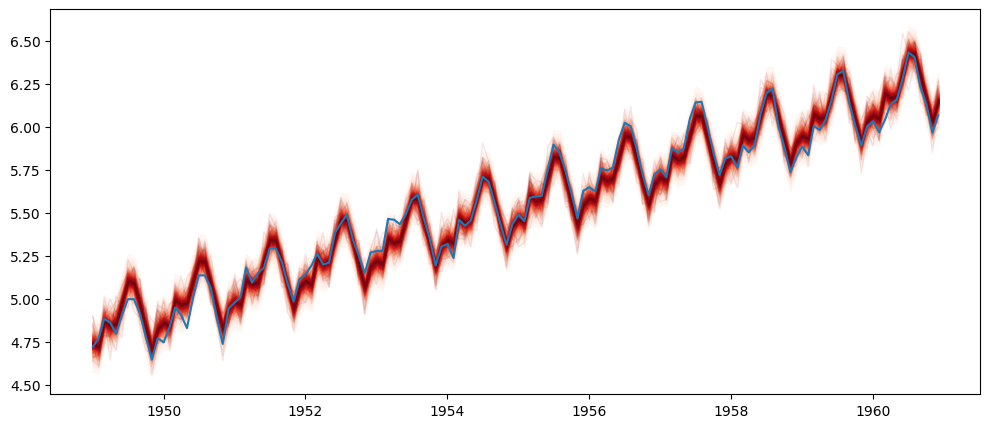

In [18]:
fig = plt.figure(figsize=(12, 5)); ax = fig.gca()

plot_gp_dist(
    ax=ax,
    samples=az.extract(trace.posterior_predictive)['observed'].T,
    x=trace.posterior_predictive.time.values,
)
ax.plot(trace.posterior_predictive.time.values, passengers['#Passengers'].apply(np.log))

plt.show()

## Part 4. HSGP (10pt)
In most cases, a trend and seasonality term do not do much together. Some structural changes may lead to correlated errors (residuals) in time that do not follow any seasonal pattern.

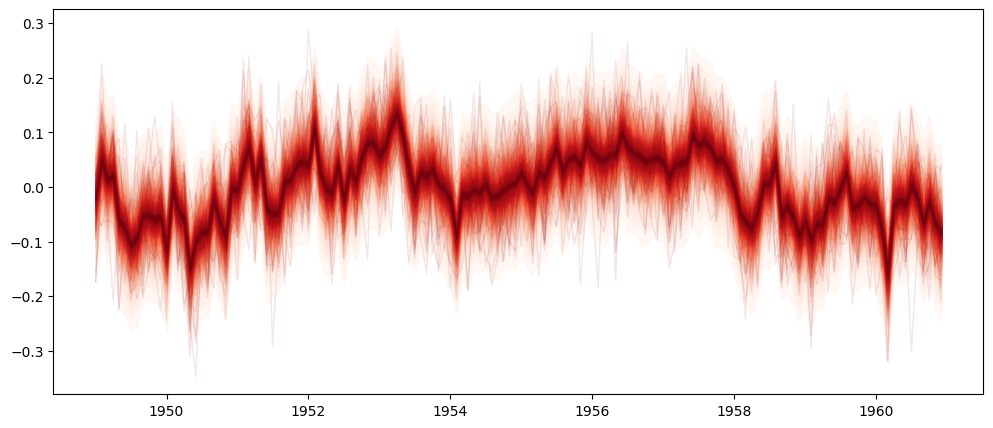

In [19]:
fig = plt.figure(figsize=(12, 5))

residuals = passengers["#Passengers"].apply(np.log).values - az.extract(trace.posterior_predictive)['observed'].values.T

plot_gp_dist(
    ax=fig.gca(),
    samples=residuals,
    x=trace.posterior_predictive.time.values,
)

plt.show()

There exists an approximation to the gaussian process, called HSGP

* https://arxiv.org/abs/2004.11408
* https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html
* https://discourse.pymc.io/t/pymcon-web-series-03a-introduction-to-hilbert-space-gps-hsgps-in-pymc-mar-15-2023-bill-engels/11533

There are not much examples about this yet, the method is very fresh. To make it even more interesting, we'll create a more granular time series, you may think, daily data.

### Under the hood

HSGP is an approximation is frequency domain, we can even see, how the eigenfunctions look like

In [20]:
L = [6] # -L, L is approximation domain
m = [7] # number of basis vectors
X = np.linspace(-5, 5) # data input domain
# eigen vectors of the Laplacian
eig_vals = pm.gp.hsgp_approx.calc_eigenvalues(L, m)
# eigen functions of the Laplacian
eig_vecs = pm.gp.hsgp_approx.calc_eigenvectors(X[:, None], L, eig_vals, m)

In [21]:
eig_vecs.shape

(50, 7)

In [22]:
eig_vals

array([[ 0.27415568,  0.27415568],
       [ 1.09662271,  1.09662271],
       [ 2.4674011 ,  2.4674011 ],
       [ 4.38649084,  4.38649084],
       [ 6.85389195,  6.85389195],
       [ 9.8696044 ,  9.8696044 ],
       [13.43362821, 13.43362821]])

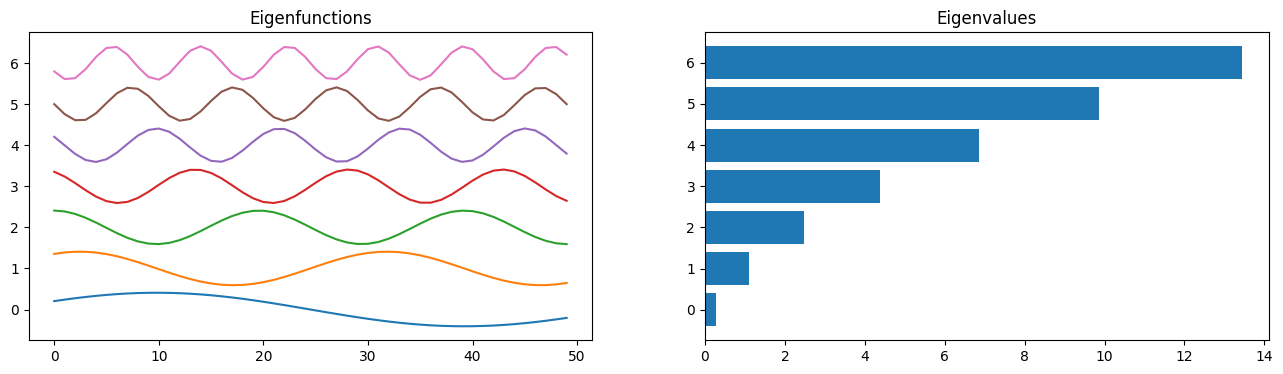

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(eig_vecs + np.arange(m[0]));
axes[0].set_title("Eigenfunctions");
axes[1].barh(np.arange(m[0]), eig_vals[:, 0]);
axes[1].set_title("Eigenvalues");

In [24]:
from scipy.interpolate import interp1d

In [25]:
interpolate = interp1d(
    x=passengers.index.to_numpy(),
    y=passengers['#Passengers'],
    assume_sorted=True,
    fill_value='extrapolate',
)

interpolated_passengers = interpolate(np.linspace(start=0, stop=passengers.shape[0], num=passengers.shape[0] * 30))
interpolated_month = pd.date_range(start=passengers['Month'].min(), end=passengers['Month'].max(),
                                   periods=interpolated_passengers.shape[0])

In [38]:
interpolated_month.shape[0] // 2

2160

sample: 100%|██████████| 2000/2000 [18:20<00:00,  1.82it/s]


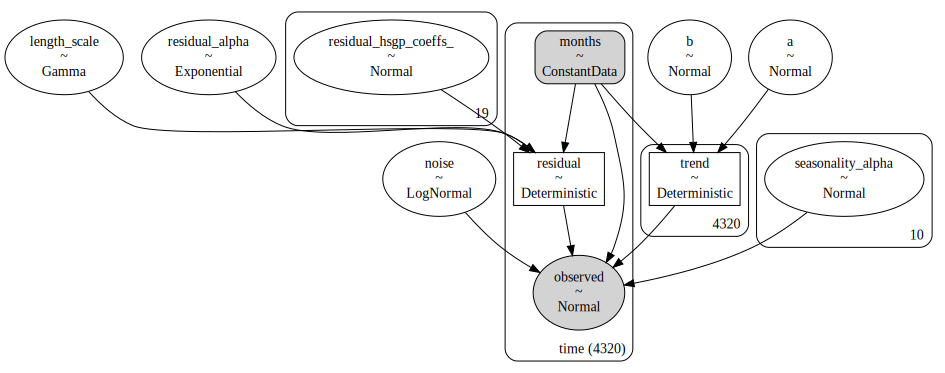

In [46]:
with pm.Model(coords=dict(time=interpolated_month)) as model4:
    # make months data: n x n
    months = pm.ConstantData(
        name='months',
        value=(np.arange(interpolated_passengers.shape[0]) - interpolated_passengers.shape[0] // 2) / 30,
        dims='time',
    )

    # constructing general trend: a + b * x
    # a: in terms of log, %
    a = pm.Normal(name='a', mu=marginal_log_mean, sigma=log_empirical_uncertainty)

    # b: in terms of absolute values
    b = pm.Normal(name='b', mu=0, sigma=log_empirical_uncertainty)

    # trend: in terms of log, %
    trend = pm.Deterministic(name='trend', var=a + b * months)

    # constructing noise
    noise = pm.LogNormal(name='noise', mu=log_empirical_uncertainty, sigma=marginal_log_std)

    # Fourier Features components
    seasonality_alpha = pm.Normal(name='seasonality_alpha', mu=0, sigma=1, shape=Monthly.Year.order * 2)
    seasonality = fourier_series(time=months, season=Monthly.Year) @ seasonality_alpha

    # Hilbert Space Gaussian Process
    length_scale = pm.Gamma(name='length_scale', mu=30, sigma=5)
    periodic = pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)
    residual_alpha = pm.Exponential('residual_alpha', 100)
    assert isinstance(periodic, pm.gp.cov.ExpQuad)

    m = [np.ceil(1.75 * 1.25 / 24 * (435 // 2))] # [np.ceil(1.75 * 1.25 / 24 * (2160 // 2))]
    L = [72 * 1.2] # [72 * 1.2]

    gaussian_processes = pm.gp.HSGP(m=m, L=L, drop_first=True, cov_func=periodic * residual_alpha)
    assert isinstance(gaussian_processes, pm.gp.HSGP)
    residual = gaussian_processes.prior(name='residual', X=months[:, None], dims='time')

    # passengers likelihood
    observed = pm.Normal(name='observed', mu=trend + seasonality + residual, sigma=noise,
                         observed=np.log(interpolated_passengers), dims='time')

    # fit model
    trace = pymc.sampling.jax.sample_numpyro_nuts(chains=2, draws=1_000, tune=1_000,chain_method='vectorized', postprocessing_backend='gpu')
    trace.extend(pm.sample_posterior_predictive(trace))
    trace.to_netcdf('trace4.nc')

pm.model_to_graphviz(model4)

Sampling may take a while, if it takes too long, try chains=1 as well.

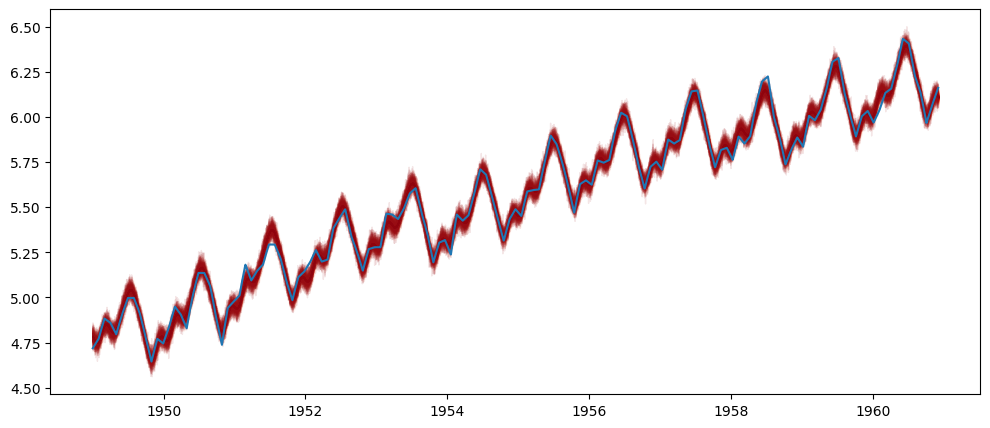

In [47]:
fig = plt.figure(figsize=(12, 5)); ax = fig.gca()

plot_gp_dist(
    ax=ax,
    samples=az.extract(trace.posterior_predictive)['observed'].T,
    x=trace.posterior_predictive.time.values,
)
ax.plot(trace.posterior_predictive.time.values, np.log(interpolated_passengers))

plt.show()

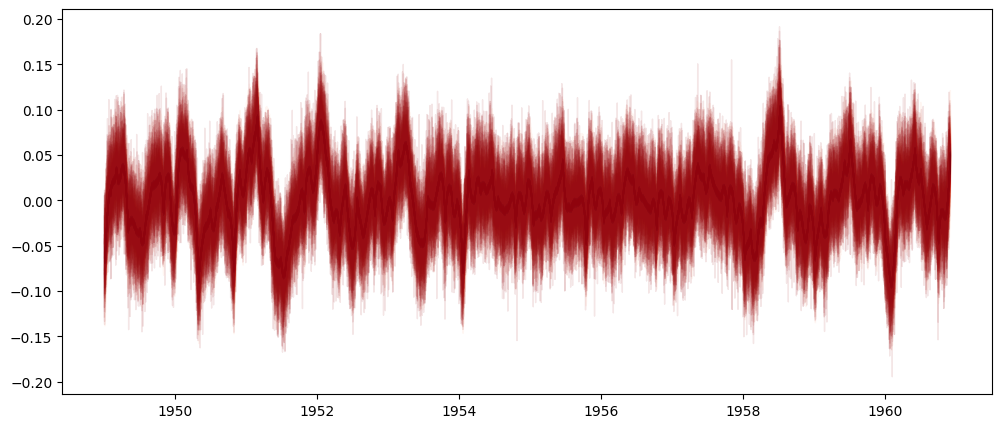

In [48]:
fig = plt.figure(figsize=(12, 5))

residuals = np.log(interpolated_passengers) - az.extract(trace.posterior_predictive)['observed'].values.T

plot_gp_dist(
    ax=fig.gca(),
    samples=residuals,
    x=trace.posterior_predictive.time.values,
)

plt.show()